In [1]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# 그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수 : 0.20에서 데이터 변환을 위한 Transformer클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈련용 데이터가
# 자주 변경이 되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)


### 위스콘신 유방암 데이터에 XG Boost 알고리즘 적용

#### 데이터 가져오기

In [2]:
# 데이터 가져오기
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()

X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
# 데이터의 분포 확인
print(cancer_df['target'].value_counts())

1    357
0    212
Name: target, dtype: int64


In [6]:
# 학습 데이터와 훈련 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.1, random_state=156 )
print(X_train.shape , X_test.shape)
print(y_train.shape , y_test.shape)

(512, 30) (57, 30)
(512,) (57,)


In [7]:
# xgboost를 이용하는 경우의 데이터 생성
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [10]:
# 하이퍼 파라미터
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

# 훈련 데이터와 검증 데이터 생성
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기
wlist = [(dtrain,'train'),(dtest,'eval') ]

# 모델 생성
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds ,early_stopping_rounds=100, evals=wlist)

# 예측
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3)) # 확률을 리턴

[0]	train-logloss:0.61040	eval-logloss:0.62134
[1]	train-logloss:0.54221	eval-logloss:0.56294
[2]	train-logloss:0.48527	eval-logloss:0.51086
[3]	train-logloss:0.43654	eval-logloss:0.47037
[4]	train-logloss:0.39239	eval-logloss:0.43128
[5]	train-logloss:0.35439	eval-logloss:0.39803
[6]	train-logloss:0.32213	eval-logloss:0.37294
[7]	train-logloss:0.29435	eval-logloss:0.34865
[8]	train-logloss:0.26891	eval-logloss:0.32692
[9]	train-logloss:0.24605	eval-logloss:0.30774
[10]	train-logloss:0.22613	eval-logloss:0.29132
[11]	train-logloss:0.20817	eval-logloss:0.27583
[12]	train-logloss:0.19236	eval-logloss:0.26334
[13]	train-logloss:0.17850	eval-logloss:0.24991
[14]	train-logloss:0.16574	eval-logloss:0.24305
[15]	train-logloss:0.15418	eval-logloss:0.22948
[16]	train-logloss:0.14412	eval-logloss:0.21837
[17]	train-logloss:0.13438	eval-logloss:0.21263
[18]	train-logloss:0.12589	eval-logloss:0.20223
[19]	train-logloss:0.11759	eval-logloss:0.19955
[20]	train-logloss:0.11056	eval-logloss:0.19101
[2

[170]	train-logloss:0.00669	eval-logloss:0.09991
[171]	train-logloss:0.00666	eval-logloss:0.10013
[172]	train-logloss:0.00664	eval-logloss:0.09963
[173]	train-logloss:0.00663	eval-logloss:0.10014
[174]	train-logloss:0.00661	eval-logloss:0.10049
[175]	train-logloss:0.00659	eval-logloss:0.10049
[176]	train-logloss:0.00657	eval-logloss:0.10059
[177]	train-logloss:0.00654	eval-logloss:0.10081
[178]	train-logloss:0.00653	eval-logloss:0.10033
[179]	train-logloss:0.00651	eval-logloss:0.10082
[180]	train-logloss:0.00647	eval-logloss:0.10071
[181]	train-logloss:0.00645	eval-logloss:0.10077
[182]	train-logloss:0.00644	eval-logloss:0.10031
[183]	train-logloss:0.00641	eval-logloss:0.10090
[184]	train-logloss:0.00640	eval-logloss:0.10069
[185]	train-logloss:0.00638	eval-logloss:0.10050
[186]	train-logloss:0.00637	eval-logloss:0.10047
[187]	train-logloss:0.00636	eval-logloss:0.10094
[188]	train-logloss:0.00634	eval-logloss:0.10076
[189]	train-logloss:0.00633	eval-logloss:0.10054
[190]	train-logloss:

[338]	train-logloss:0.00506	eval-logloss:0.09686
[339]	train-logloss:0.00505	eval-logloss:0.09660
[340]	train-logloss:0.00504	eval-logloss:0.09665
[341]	train-logloss:0.00504	eval-logloss:0.09661
[342]	train-logloss:0.00503	eval-logloss:0.09643
[343]	train-logloss:0.00503	eval-logloss:0.09633
[344]	train-logloss:0.00502	eval-logloss:0.09596
[345]	train-logloss:0.00502	eval-logloss:0.09572
[346]	train-logloss:0.00501	eval-logloss:0.09563
[347]	train-logloss:0.00501	eval-logloss:0.09579
[348]	train-logloss:0.00500	eval-logloss:0.09583
[349]	train-logloss:0.00499	eval-logloss:0.09558
[350]	train-logloss:0.00499	eval-logloss:0.09591
[351]	train-logloss:0.00498	eval-logloss:0.09618
[352]	train-logloss:0.00498	eval-logloss:0.09600
[353]	train-logloss:0.00497	eval-logloss:0.09596
[354]	train-logloss:0.00497	eval-logloss:0.09600
[355]	train-logloss:0.00496	eval-logloss:0.09575
[356]	train-logloss:0.00496	eval-logloss:0.09539
[357]	train-logloss:0.00495	eval-logloss:0.09565
[358]	train-logloss:

In [11]:
# 확률을 가지고 실제 클래스를 예측
# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [25]:
# 평가 지표 확인
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 오차 행렬
confusion = confusion_matrix(y_test, preds)
print(confusion)

# 정확도
accuracy = accuracy_score(y_test, preds)
print("정확도:",accuracy)

# 정밀도 - True로 판정한 것 중에서 실제 True인 비율 : 잘못 검색되면 안되는 경우
# 예를 들어 아동이 볼 만한 동영상을 검색했을 때
precision = precision_score(y_test, preds)
print("정밀도:",precision)

# 재현율 - 실제로 True인 것 중에서 True로 판정한 비율 : 정보 검색
recall = recall_score(y_test, preds)
print("재현율:",recall)

# f1_score : 정밀도와 재현율의 조화 평균 - 데이터가 불균형할 때 중요
f1 = f1_score(y_test,preds)
print("f1 score:",f1)

# roc_auc : 1에 가까울수록 좋은 수치
roc_auc = roc_auc_score(y_test, pred_probs)
print("roc_auc:",roc_auc)


[[17  1]
 [ 1 38]]
정확도: 0.9649122807017544
정밀도: 0.9743589743589743
재현율: 0.9743589743589743
f1 score: 0.9743589743589743
roc_auc: 0.9914529914529914


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

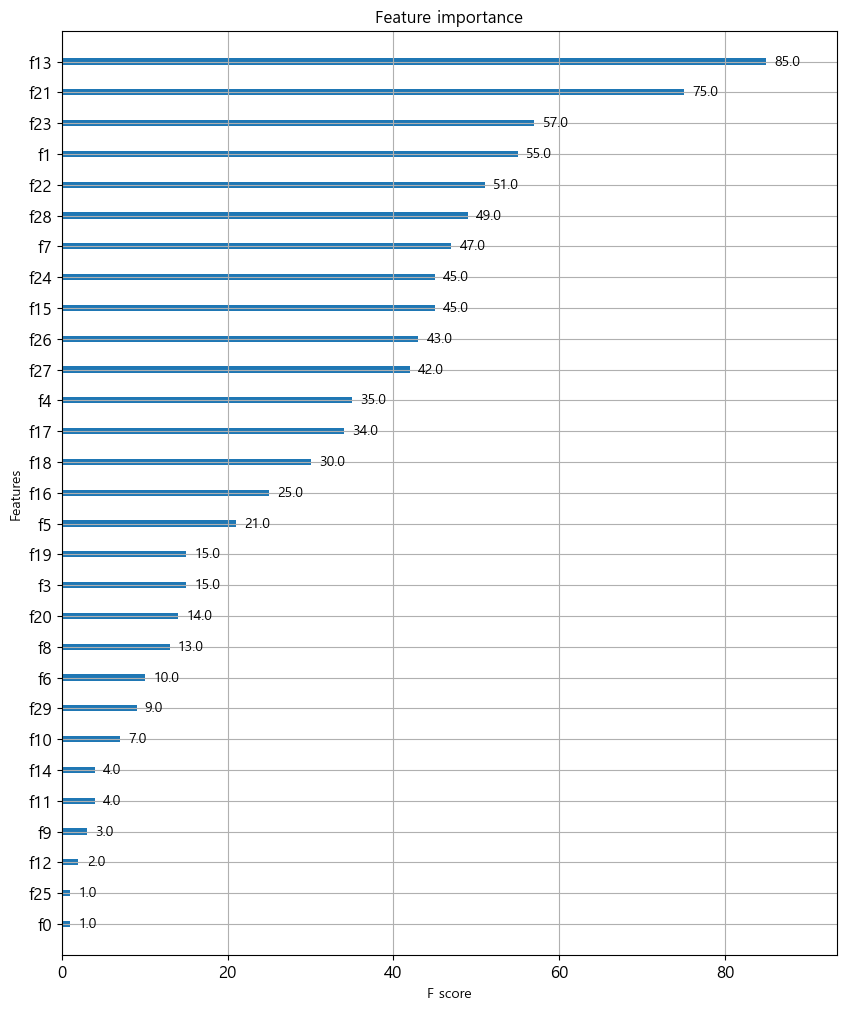

In [26]:
# 피처의 중요도
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

In [27]:
!pip install lightgbm

     ---------------------------------------- 1.3/1.3 MB 10.4 MB/s eta 0:00:00


### 위스콘신 유방암 데이터에 Light GBM 적용

In [31]:
from lightgbm import LGBMClassifier

# 예측기의 개수를 400으로 해서 LightGBM 모델 생성
lgbm_clf = LGBMClassifier(n_estimators = 400)

# 평가 데이터를 생성
evals = [(X_test,y_test)]

# 훈련
lgbm_clf.fit(X_train, y_train, eval_metric="logloss", eval_set=evals)

[LightGBM] [Info] Number of positive: 318, number of negative: 194
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5106
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.621094 -> initscore=0.494193
[LightGBM] [Info] Start training from score 0.494193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(n_estimators=400)

In [32]:
preds = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]
print(preds[:10])
print(pred_proba[:10])

[1 0 1 0 1 1 1 1 1 0]
[8.103e-01 1.414e-06 9.984e-01 2.700e-02 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.380e-08]


In [33]:
# 오차 행렬
confusion = confusion_matrix(y_test, preds)
print(confusion)

# 정확도
accuracy = accuracy_score(y_test, preds)
print("정확도:",accuracy)

# 정밀도 - True로 판정한 것 중에서 실제 True인 비율 : 잘못 검색되면 안되는 경우
# 예를 들어 아동이 볼 만한 동영상을 검색했을 때
precision = precision_score(y_test, preds)
print("정밀도:",precision)

# 재현율 - 실제로 True인 것 중에서 True로 판정한 비율 : 정보 검색
recall = recall_score(y_test, preds)
print("재현율:",recall)

# f1_score : 정밀도와 재현율의 조화 평균 - 데이터가 불균형할 때 중요
f1 = f1_score(y_test,preds)
print("f1 score:",f1)

# roc_auc : 1에 가까울수록 좋은 수치
roc_auc = roc_auc_score(y_test, pred_probs)
print("roc_auc:",roc_auc)



[[17  1]
 [ 1 38]]
정확도: 0.9649122807017544
정밀도: 0.9743589743589743
재현율: 0.9743589743589743
f1 score: 0.9743589743589743
roc_auc: 0.9914529914529914


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

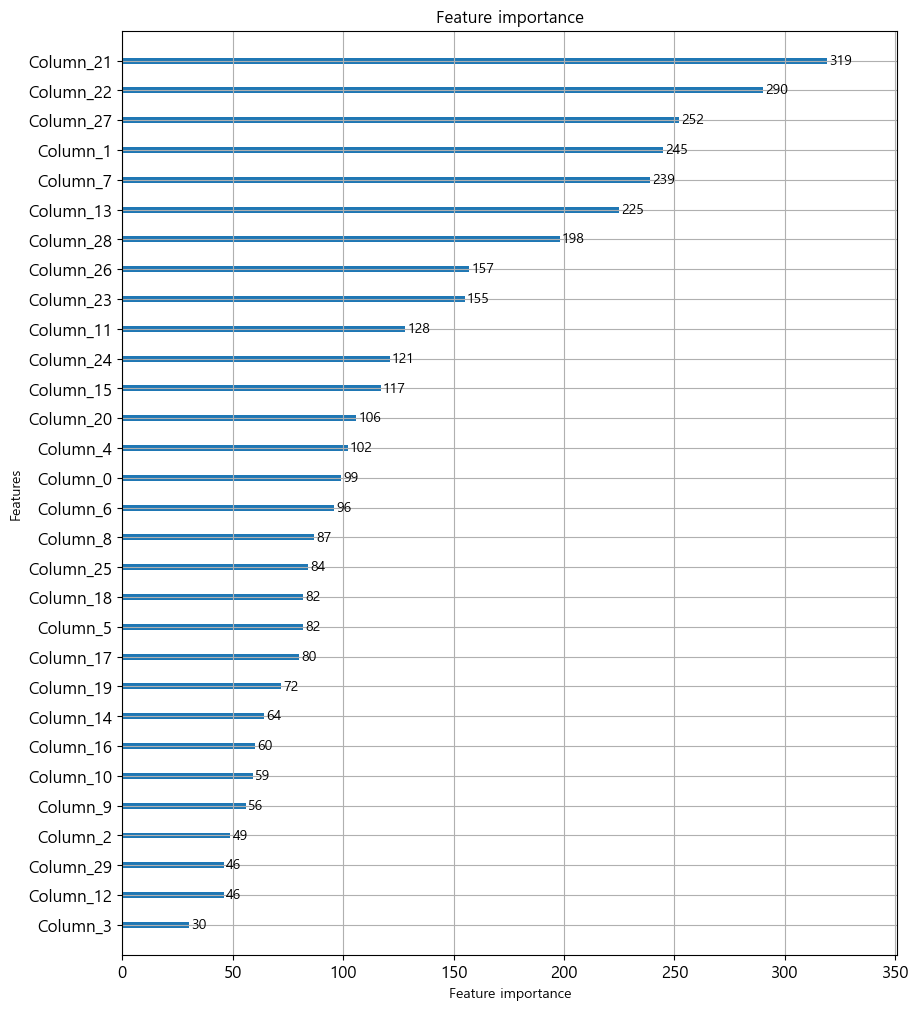

In [34]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_clf, ax=ax)

### 위스콘 신 유방암 데이터를 가지고 개별 훈련기와 Stacking의 차이를 학습

In [35]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
# 데이터 생성
cancer_data = load_breast_cancer()
X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=42)


In [37]:
# 개별 모델 생성
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 모델 생성(로지스틱)
# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

In [38]:
# 개별 모델 훈련
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [39]:
# 예측 데이터 셋 생성, 개별 훈련기의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9386
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9474
에이다부스트 정확도: 0.9737


In [41]:
# 모델이 예측한 결과를 가지고 새로운 데이터를 생성
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# 행열을 전치
# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [48]:
# 결과를 가지고 다시 훈련
lr_final.fit(pred, y_test)
final_pred = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도:',accuracy_score(y_test, final_pred))

최종 메타 모델의 예측 정확도: 0.9736842105263158


## Kaggle

In [49]:
import pandas as pd

data_path="./data/data/data/cfec/"

train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

print(type(submission))

<class 'pandas.core.frame.DataFrame'>


In [50]:
print(train.shape, test.shape)

(300000, 24) (200000, 23)


In [51]:
print(train.head())

    bin_0  bin_1  bin_2 bin_3 bin_4  nom_0      nom_1    nom_2    nom_3  \
id                                                                        
0       0      0      0     T     Y  Green   Triangle    Snake  Finland   
1       0      1      0     T     Y  Green  Trapezoid  Hamster   Russia   
2       0      0      0     F     Y   Blue  Trapezoid     Lion   Russia   
3       0      1      0     F     Y    Red  Trapezoid    Snake   Canada   
4       0      0      0     F     N    Red  Trapezoid     Lion   Canada   

       nom_4  ...      nom_9 ord_0        ord_1        ord_2 ord_3  ord_4  \
id            ...                                                           
0    Bassoon  ...  2f4cb3d51     2  Grandmaster         Cold     h      D   
1      Piano  ...  f83c56c21     1  Grandmaster          Hot     a      A   
2   Theremin  ...  ae6800dd0     1       Expert     Lava Hot     h      R   
3       Oboe  ...  8270f0d71     1  Grandmaster  Boiling Hot     i      D   
4       Oboe

In [52]:
submission.head()
# 답안은 클래스가 아니고 확률로 제출

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


In [55]:
# 피처의 정보를 요약해주는 함수
def resumetable(df) :
    print("데이터 구조:", df.shape)
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고유값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    return summary

resumetable(train)

데이터 구조: (300000, 24)


,피처,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [60]:
# 순서형 피처 목록 확인(중복 제거하고 고유값 목록만 들고오기)
for i in range(3) :
    feature = 'ord_' + str(i)
    # 문자열이 아닌 데이터를 출력하고자 하는 경우
    # f'{데이터}''
    print(feature + f'고유 값:{train[feature].unique()}')
    

ord_0고유 값:[2 1 3]
ord_1고유 값:['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2고유 값:['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


In [64]:
# 순서형 피처 목록 확인(중복 제거하고 고유값 목록만 들고오기)
for i in range(3,6) :
    feature = 'ord_' + str(i)
    # 문자열이 아닌 데이터를 출력하고자 하는 경우
    # f'{데이터}''
    print(feature + f'고유 값:{train[feature].unique()}')

ord_3고유 값:['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4고유 값:['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5고유 값:['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'dZ' 'yN' 'Nf' 'QM' 'jV' 'sY' 'wu' 'SB'
 'UO' 'Mx' 'JX' 'Ry' 'Uk' 'uJ' 'LE' 'ps' 'kE' 'MO' 'kw' 'yY' 'zU' 'bJ'
 'Kf' 'ck' 'mb' 'Os'

In [68]:
print('day 고윳값:', train['day'].unique())
print('month 고윳값:', train['month'].unique())
print('target 고윳값:', train['target'].unique())

day 고윳값: [2 7 5 4 3 1 6]
month 고윳값: [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고윳값: [0 1]


### 시각화를 이용한 데이터 탐색

[Text(0.5, 1.0, 'Target Distribution')]

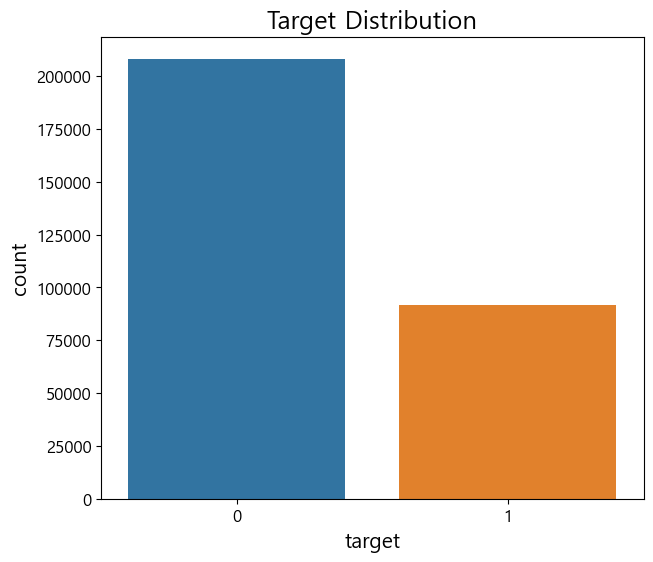

In [70]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15) # 폰트 크기 설정
plt.figure(figsize=(7, 6)) # Figure 크기 설정

ax = sns.countplot(x='target', data=train)
ax.set(title='Target Distribution')

In [74]:
# 첫 번째 막대에 대한 정보 확인
rectangle = ax.patches[0]
print('사각형 높이:', rectangle.get_height())
print('사각형 너비:', rectangle.get_width())
print('사각형 왼쪽 테두리의 x축 위치:', rectangle.get_x())


사각형 높이: 208236.0
사각형 너비: 0.8
사각형 왼쪽 테두리의 x축 위치: -0.4


Text(0.5, 1.0, 'Target Distribution')

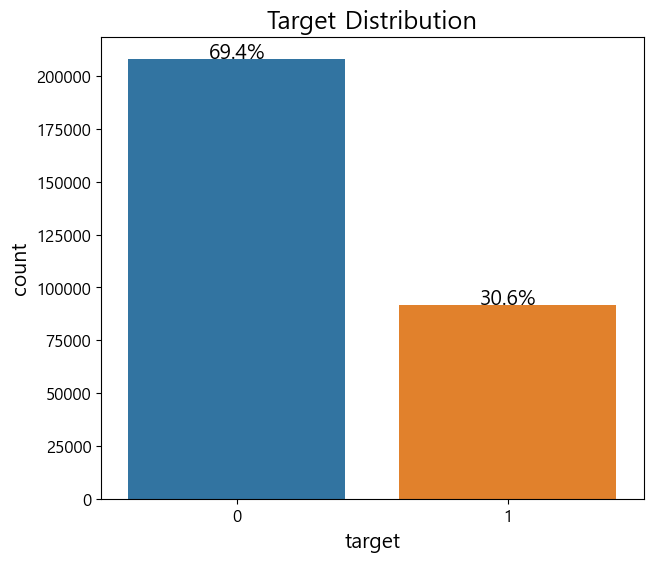

In [75]:
# 텍스트 출력 - 비율을 표시
def write_percent(ax, total_size):
    for patch in ax.patches :
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        
        # 막대의 높이를 이용해서 비율을 구하기
        percent = height / total_size * 100
        
        # 텍스트 출력
        ax.text(x=left_coord + width/2.0,
               y = height + total_size * 0.001,
               s = f'{percent:1.1f}%',
               ha = 'center')

plt.figure(figsize=(7,6))
ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train))
ax.set_title('Target Distribution')

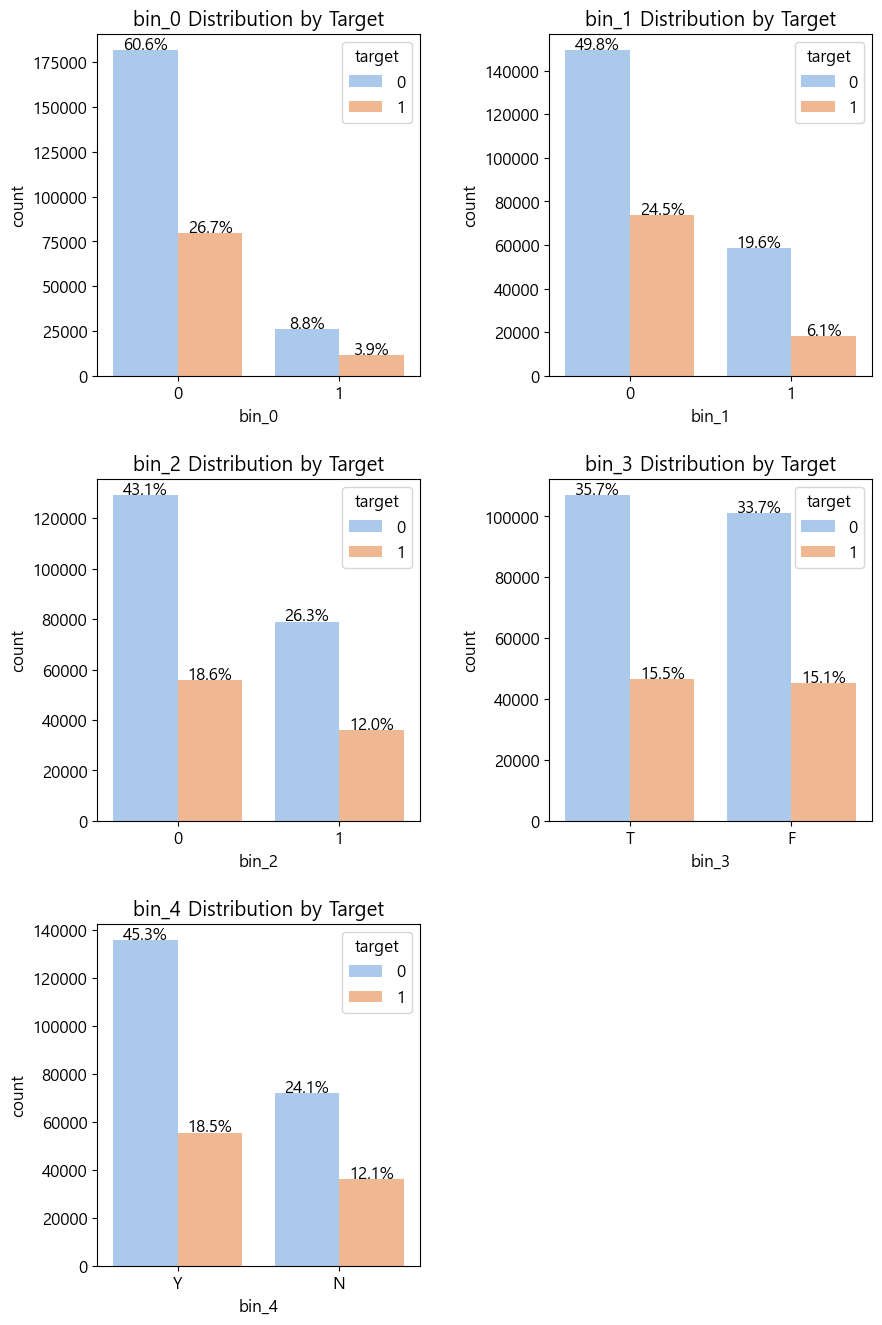

In [81]:
# 여러 개의 이진 데이터 분포 확인
# 여러 개의 이미지를 출력할 때 사용하는 격자
import matplotlib.gridspec as gridspec

mpl.rc('font', size=12)
grid = gridspec.GridSpec(3, 2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10,16))
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

# 시각화할 컬럼 리스트
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4'] # 피처 목록

for idx, feature in enumerate(bin_features):
    ax = plt.subplot(grid[idx])
    
    sns.countplot(x = feature, data=train, hue='target', palette='pastel', ax=ax)
    
    ax.set_title(f'{feature} Distribution by Target') # 그래프 제목 설정
    write_percent(ax, len(train))
    

### 교차 분석표를 이용한 데이터 분포 확인

In [82]:
pd.crosstab(train['nom_0'], train['target'])

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


In [83]:
# 백분율로 보기
crosstab = pd.crosstab(train['nom_0'], train['target'], normalize='index')*100
crosstab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [85]:
# 인덱스를 인련번호로 수정
crosstab = crosstab.reset_index()
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


In [86]:
# 교차 분석표를 생성하는 함수(매번 같은거 쓰면 오래 걸리기 때문에 함수로 지정하기)

def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

crosstab = get_crosstab(train, 'nom_0')
crosstab


target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


## 데이터 전처리

In [88]:
# ord_1은 Novice, Contributor, Expert, Master, GrandMaster 순으로 카테고리를 설정
# ord_2는 Freezing, Cold, Warm, Hot, Boiling Hot, Lava Hot

from pandas.api.types import CategoricalDtype
ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'GrandMaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

# 문자열 list를 타입으로 생성 -enum
ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

# 데이터 타입 변경
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)


## 기본 모델링

### 데이터 가져오기

In [108]:
import pandas as pd

data_path="./data/data/data/cfec/"

train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

In [109]:
# 훈련 데이터와 테스트 데이터를 합치기
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1) # 타겟은 전처리 대상이 아니므로 제거
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,...,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,...,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,...,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1


In [110]:
# 범주형 데이터를 원 핫 인코딩
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder() # 원-핫 인코더 생성
all_data_encoded = encoder.fit_transform(all_data) # 원 핫 인코딩 적용

In [111]:
# 훈련 데이터와 테스트 데이터 분리
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_encoded[:num_train] # 0 ~ num_train - 1행
X_test = all_data_encoded[num_train:] # num_train ~ 마지막 행
y = train['target']

In [112]:
# 훈련에 사용할 데이터와 검증을 위한 데이터 분리
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
# 층화 추출을 이용해서 테스트 데이터와 검증용 데이터 생성(0과 1이 차이가 많이 나서 층화추출 이용)
# stratify=y -> y의
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, test_size=0.3, stratify=y, random_state=10)



### 모델 생성 및 훈련

In [113]:
# 이진 분류 이므로 모든 분류기 사용 가능
from sklearn.linear_model import LogisticRegression

# 모델 만들기
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# 훈련
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [114]:
# 예측
logistic_model.predict(X_valid)

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [115]:
## 평가 지표 확인 - ROC AUC
y_valid_preds = logistic_model.predict_proba(X_valid)[:, 1]
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print("평가 점수 : ", roc_auc)

평가 점수 :  0.794521881880898


### 제출할 결과 파일 생성

In [116]:
# 타깃값 1일 확률 예측
y_preds = logistic_model.predict_proba(X_test)[:, 1]

# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission.csv')

## 모델 수정

In [117]:
#데이터 확인
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8


## 이진 피처 인코딩 수정

In [118]:
# 문자로 된 경우 숫자로 수정
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'N':0, 'Y':1})
print(all_data.head())

    bin_0  bin_1  bin_2  bin_3  bin_4  nom_0      nom_1    nom_2    nom_3  \
id                                                                          
0       0      0      0      1      1  Green   Triangle    Snake  Finland   
1       0      1      0      1      1  Green  Trapezoid  Hamster   Russia   
2       0      0      0      0      1   Blue  Trapezoid     Lion   Russia   
3       0      1      0      0      1    Red  Trapezoid    Snake   Canada   
4       0      0      0      0      0    Red  Trapezoid     Lion   Canada   

       nom_4  ...      nom_8      nom_9 ord_0        ord_1        ord_2  \
id            ...                                                         
0    Bassoon  ...  c389000ab  2f4cb3d51     2  Grandmaster         Cold   
1      Piano  ...  4cd920251  f83c56c21     1  Grandmaster          Hot   
2   Theremin  ...  de9c9f684  ae6800dd0     1       Expert     Lava Hot   
3       Oboe  ...  4ade6ab69  8270f0d71     1  Grandmaster  Boiling Hot   
4       Ob

In [119]:
ord1dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)
all_data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,1,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,4,1,h,D,kr,2,2
1,0,1,0,1,1,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,4,3,a,A,bF,7,8
2,0,0,0,0,1,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,2,5,h,R,Jc,7,2
3,0,1,0,0,1,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,4,4,i,D,kW,2,1
4,0,0,0,0,0,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,4,0,a,R,qP,7,8


In [120]:
# ord_3, ord_4, ord_5 는 순서가 있는 범주형이므로 One Hot Encoding 대신에
# Ordinal Encoding을 수행

from sklearn.preprocessing import OrdinalEncoder
ord_345 = ['ord_3', 'ord_4', 'ord_5']
ord_encoder = OrdinalEncoder() # OrdinalEncoder 객체 생성
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])
for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

### 명목형 목록 인코딩

In [130]:
nom_features = ['nom_' + str(i) for i in range(10)] # 명목형 피처
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
# 원-핫 인코딩 적용
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])

all_data = all_data.drop(nom_features, axis=1) # 기존 명목형 피처 삭제
print(encoded_nom_matrix)

KeyError: "None of [Index(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7',\n       'nom_8', 'nom_9'],\n      dtype='object')] are in the [columns]"

### 날짜 목록 인코딩

In [125]:
date_features = ['day', 'month']
encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])
all_data = all_data.drop(date_features, axis=1)
print(encoded_date_matrix)

  (0, 1)	1.0
  (0, 8)	1.0
  (1, 6)	1.0
  (1, 14)	1.0
  (2, 6)	1.0
  (2, 8)	1.0
  (3, 1)	1.0
  (3, 7)	1.0
  (4, 6)	1.0
  (4, 14)	1.0
  (5, 1)	1.0
  (5, 8)	1.0
  (6, 4)	1.0
  (6, 10)	1.0
  (7, 3)	1.0
  (7, 8)	1.0
  (8, 2)	1.0
  (8, 10)	1.0
  (9, 2)	1.0
  (9, 8)	1.0
  (10, 2)	1.0
  (10, 16)	1.0
  (11, 6)	1.0
  (11, 8)	1.0
  (12, 2)	1.0
  :	:
  (499987, 9)	1.0
  (499988, 0)	1.0
  (499988, 16)	1.0
  (499989, 2)	1.0
  (499989, 9)	1.0
  (499990, 1)	1.0
  (499990, 14)	1.0
  (499991, 1)	1.0
  (499991, 13)	1.0
  (499992, 3)	1.0
  (499992, 16)	1.0
  (499993, 1)	1.0
  (499993, 14)	1.0
  (499994, 3)	1.0
  (499994, 7)	1.0
  (499995, 0)	1.0
  (499995, 9)	1.0
  (499996, 1)	1.0
  (499996, 8)	1.0
  (499997, 2)	1.0
  (499997, 7)	1.0
  (499998, 1)	1.0
  (499998, 7)	1.0
  (499999, 1)	1.0
  (499999, 8)	1.0


### 순서형 목록은 스케일링

In [126]:
from sklearn.preprocessing import MinMaxScaler

ord_features = ['ord_' + str(i) for i in range(6)] # 순서형 피처
# min-max 정규화
all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])
all_data[ord_features]

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
id,,,,,,
0,0.5,1.00,0.2,0.500000,0.12,0.712042
1,0.0,1.00,0.6,0.000000,0.00,0.486911
2,0.0,0.50,1.0,0.500000,0.68,0.162304
3,0.0,1.00,0.8,0.571429,0.12,0.701571
4,0.0,1.00,0.0,0.000000,0.68,0.827225
...,...,...,...,...,...,...
499995,0.0,0.00,1.0,0.642857,0.00,0.130890
499996,0.0,0.25,1.0,0.357143,0.72,0.089005
499997,0.0,0.00,0.8,0.428571,0.84,0.345550


## 인코딩한 데이터와 스케일링한 데이터 합치기

In [127]:
from scipy import sparse

# 인코딩 및 스케일링된 피처 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
encoded_nom_matrix,
encoded_date_matrix],
format='csr')
all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

## 훈련 데이터와 검증 데이터 생성

In [128]:
# 훈련 데이터와 검증 데이터 생성
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_sprs[:num_train] # 0 ~ num_train - 1행
X_test = all_data_sprs[num_train:] # num_train ~ 마지막 행
y = train['target']

from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y,
test_size=0.3,
stratify=y,
random_state=10)


## 하이퍼 파라미터 튜닝

In [129]:
from sklearn.model_selection import GridSearchCV
logistic_model = LogisticRegression()

lr_params = {'C':[0.1, 0.125, 0.2], 'max_iter':[800, 900, 1000], 
'solver':['liblinear'], 'random_state':[42]}

gridsearch_logistic_model = GridSearchCV(estimator=logistic_model,
param_grid=lr_params,
scoring='roc_auc', # 평가지표
cv=5)


gridsearch_logistic_model.fit(X_train, y_train)
print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)


최적 하이퍼파라미터: {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}
